<a href="https://colab.research.google.com/github/bcastiblancoo/Experimental-High-Energy-Physics---Subject/blob/main/FinalProject/(Jet-cuts-more-plots)Optimized_13TeV_pds_HZZAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**First time setup on your computer**

This first cell only needs to be run the first time you open this notebook on your computer.

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

**To setup everytime**

We're going to be using a number of tools to help us:

**uproot**: lets us read .root files typically used in particle physics into data formats used in python

**awkward:** lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists

**vector:** to allow vectorized 4-momentum calculations

**numpy:** provides numerical calculations such as histogramming

**matplotlib:** common tool for making plots, figures, images, visualisations

In [1]:
import sys
!pip install uproot3 vector numpy matplotlib #awkward

In [2]:
import uproot3 # library for reading .root files
import pandas as pd # to represent nested data in columnar format
#import awkward as ak
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
import infofile

**Lumi, fraction, file path**

General definitions of fraction of data used, where to access the input files

In [3]:
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

**samples to process**

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },
    
    r'$ZZ$' : { # ZZ and diboson background
        'list' : ['llll','ZqqZll','llvv','lllv'], #'lvvv'
        'color' : "#ffe900" # 046865 Middle yellow # 046865 Skobeloff
    },

    r'$Z+jets$' : { # Z + jets
        'list' : ['Zee','Zmumu','Ztautau'],
        'color' : "#6b59d3" # Slate blue   
    },
    
    r'ttbar,single-top' : { # t decay
        'list' : ['ttbar_lep','single_top_tchan','single_antitop_tchan','single_antitop_schan','single_top_wtchan','single_antitop_wtchan'],
        'color' : "#00cdff" # light blue
    },

    r'Higgs ($m_H$ = 125 GeV)' : { # Higgs boson decay: H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#ff0000" # Red
    },

}

Units, as stored in the data files

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [5]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    nIn_total=0
    nOut_total=0
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp,nIn,nOut = read_file(fileString,val) # call the function read_file defined below
            nIn_total+=nIn
            nOut_total+=nOut
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
            #print(temp['lep_pt'])
            #print(temp['mllll'])
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data, nIn_total, nOut_total # return dictionary of dataframes

define function to calculate weight of MC event

In [6]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight * mcWeight * scaleFactor_PILEUP * scaleFactor_ELE * scaleFactor_MUON  * scaleFactor_LepTRIGGER)

define function to get cross-section weight

In [7]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate 4-lepton invariant mass.

Note: lep_(pt|eta|phi|E) are variable length lists of lepton momentum components for each event, represented by awkward arrays.

In [8]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lepton[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lepton[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lepton[2] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lepton[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lepton[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lepton[3] momentum    
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

In [9]:
def calc_mll12(lep_pt, lep_eta, lep_phi, lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    sumpx = px_0 + px_1  # x-component of momentum
    sumpy = py_0 + py_1  # y-component of momentum
    sumpz = pz_0 + pz_1  # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

In [19]:
def calc_mll34(lep_pt, lep_eta, lep_phi, lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_3 = lep_pt[2]*math.cos(lep_phi[2]) 
    py_3 = lep_pt[2]*math.sin(lep_phi[2]) 
    pz_3 = lep_pt[2]*math.sinh(lep_eta[2])
    px_4 = lep_pt[3]*math.cos(lep_phi[3]) 
    py_4 = lep_pt[3]*math.sin(lep_phi[3]) 
    pz_4 = lep_pt[3]*math.sinh(lep_eta[3]) 
    sumpx = px_3 + px_4  # x-component of momentum
    sumpy = py_3 + py_4  # y-component of momentum
    sumpz = pz_3 + pz_4  # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[2] + lep_E[3] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

In [11]:
def leadlepton_pt(lep_pt):
  return lep_pt[0]/1000.

In [12]:
def number_jets(jet_n):
  return jet_n

In [13]:
def number_leptons(lep_n):
  return lep_n

In [14]:
def lepton_charge(lep_charge):
  for i in range(0,3):
    return lep_charge[i]

In [15]:
def lepton_flavour(lep_type):
  for i in range (0,3):
    return lep_type[i]

**Changing a cut**


If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "Applying a cut" cell.

In [20]:
def trigger(trigE, trigM):
    if((trigE != True) and (trigM != True)): 
      return True
    return False

def goodlep_cut(lep_n, lep_pt, lep_eta, lep_ptcone30, lep_etcone20, lep_type, lep_isTightID):
    goodlep_n=0

    for i in range (lep_n):
        #if(lep_isTightID[i]==False): 
        #  continue
        #Lepton is highly isolated and hard
        if(lep_pt[i]<=5000. or (lep_ptcone30[i]/lep_pt[i]>=0.3) or (lep_etcone20[i]/lep_pt[i]>=0.3)): 
          continue
        # electron selection in fiducial region excluding candidates in the transition region between 
        #the barrel and endcap electromagnetic calorimeters
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)):
            goodlep_n+=1
        # muon selection
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            goodlep_n+=1
                   
    if(goodlep_n==4): 
      return False
    return True    

def cut_lep_pt(lep_pt):
    return lep_pt[0]<25000. or lep_pt[1]<15000. or lep_pt[2]<10000. or lep_pt[3]<7000.

def cut_lep_charge(lep_charge):     
    if(lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0): 
      return True
    return False
    
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    if((sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)): 
      return True
    return False

def cut_number_jets(jet_n):
  if jet_n != 0:
    return True
  return False    

**Applying a cut**


If you add a cut: Cell -> Run All Below

In [21]:
def read_file(path,sample):
    
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    nIn_total=0
    nOut_total=0
    for data in tree.iterate(['lep_charge','lep_type','lep_pt',
                              'lep_ptcone30','lep_etcone20','lep_isTightID',
                              'lep_eta','lep_phi','lep_E','lep_n',
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER','trigE','trigM','jet_n'], # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        nIn_total+=nIn
        #print(data[['lep_pt', 'mcWeight']])
        nOut = 0
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)
        
        #cut on trigger
        fail = data[np.vectorize(trigger)(data.trigE, data.trigM) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than
        if len(data.index)==0: 
          continue # move onto next batch if no events left 

        #cut on goodlepton
        fail = data[np.vectorize(goodlep_cut)(data.lep_n, data.lep_pt, data.lep_eta, data.lep_ptcone30, 
                                               data.lep_etcone20, data.lep_type, data.lep_isTightID) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than
        if len(data.index)==0: 
          continue # move onto next batch if no events left

        #Cut on lepton pTs:
        fail = data[np.vectorize(cut_lep_pt)(data.lep_pt)].index
        data.drop(fail,inplace=True)
        if len(data.index)==0:
          continue

        #cut on charge and lepton type:       
        
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0:
          continue # move onto next batch if no events left
            
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0:
          continue # move onto next batch if no events left

        #cur on number of jets:

        fail = data[ np.vectorize(cut_number_jets)(data.jet_n) ].index # get events that fail this selection
        data.drop(fail,inplace=True)  
        if len(data.index)==0:
          continue # move onto next batch if no events left  

        data['leadlepton_pt'] = np.vectorize(leadlepton_pt)(data.lep_pt)
        data['number_leptons'] = np.vectorize(number_leptons)(data.lep_n)
        data['number_jets'] = np.vectorize(number_jets)(data.jet_n)
        data['lepton_charge'] = np.vectorize(lepton_charge)(data.lep_charge)#,data.lep_n)
        data['lepton_type'] = np.vectorize(lepton_flavour)(data.lep_type)#,data.lep_type)

        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        data['mll12'] = np.vectorize(calc_mll12)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        data['mll34'] = np.vectorize(calc_mll34)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        nOut = len(data.index) # number of events passing cuts in this batch
        nOut_total+=nOut
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        #print(data[['lep_pt', 'mllll']])
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after
    
    print("\t\t nIn_total: "+str(nIn_total)+",\t nOut_total: \t"+str(nOut_total))

    return data_all, nIn_total, nOut_total # return dataframe containing events passing all cuts

This is where the processing happens

In [22]:
data,nIn_total,nOut_total = get_data_from_files()
print("Number of input events:",nIn_total)
print("Number of output events:",nOut_total)

Processing data samples
	Processing: data_A
		 nIn: 39,	 nOut: 	9
		 nIn_total: 39,	 nOut_total: 	9
	Processing: data_B
		 nIn: 156,	 nOut: 	26
		 nIn_total: 156,	 nOut_total: 	26
	Processing: data_C
		 nIn: 237,	 nOut: 	52
		 nIn_total: 237,	 nOut_total: 	52
	Processing: data_D
		 nIn: 400,	 nOut: 	96
		 nIn_total: 400,	 nOut_total: 	96
Processing $ZZ$ samples
	Processing: llll
		 nIn: 106415,	 nOut: 	24906
		 nIn: 106415,	 nOut: 	24950
		 nIn: 106415,	 nOut: 	25086
		 nIn: 106415,	 nOut: 	25247
		 nIn: 106415,	 nOut: 	25269
		 nIn: 22204,	 nOut: 	5204
		 nIn_total: 554279,	 nOut_total: 	130662
	Processing: ZqqZll
		 nIn: 254,	 nOut: 	9
		 nIn_total: 254,	 nOut_total: 	9
	Processing: llvv
		 nIn: 137,	 nOut: 	2
		 nIn_total: 137,	 nOut_total: 	2
	Processing: lllv
		 nIn: 9340,	 nOut: 	251
		 nIn_total: 9340,	 nOut_total: 	251
Processing $Z+jets$ samples
	Processing: Zee
		 nIn: 898,	 nOut: 	67
		 nIn_total: 898,	 nOut_total: 	67
	Processing: Zmumu
		 nIn: 684,	 nOut: 	61
		 nIn_total:

**Plotting**

If you only want to make a change in plotting: Cell -> Run All Below

Define function to plot the data

In [23]:
def plot_mH(data):

    xmin = 80 #GeV
    xmax = 176  #GeV
    step_size = 8 #Gev/bin

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    signal_x = data[r'Higgs ($m_H$ = 125 GeV)']['mllll'] # histogram the signal
    signal_weights = data[r'Higgs ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Higgs ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar


    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Higgs ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************
    #plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    #Calculate the Data/Pred. ratio, taking the closest value of the data to the MC value

    data_pred=(data_x-data_x_errors)/mc_x_tot
    #errormc_x_tot=np.sqrt(mc_x_err) #statistical error in MC data
    #data_pred_errors=data_pred*np.sqrt(((data_x-data_x_errors)/data_x_errors)**2+(mc_x_tot/mc_x_err)**2)   
    data_pred_errors=np.sqrt(data_pred) #stat. unc.

    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Higgs ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    #main_axes.set_xlabel(r'$\mathrm{m_{T}(4l)}$ [GeV]',
    #                    fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    """
    plt.text(0.05, # x
             0.76, # y
             'Reproduced it by: B. Castiblanco', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    """
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.125,-0.1,0.775,0.225]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    sub_axes.set_ylim(bottom=0, top=np.amax(data_pred)*1.5)

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_pred, yerr=data_pred_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles

    sub_axes.axhline(1.0,ls='--',c='b')
    sub_axes.axvline(125.0,ls='--',c='r')                  

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_xticks([80,90,100,110,120,130,140,150,160,170]) 
    
    # x-axis label
    sub_axes.set_xlabel(r'$\mathrm{m_{4\ell}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 )
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_yticks([-1.0,0,1.0,2.0])

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Data/Pred' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

    plt.savefig("m_H.png",bbox_inches='tight')

    return

Finally, plotting the transversed invariant mass for the 4 final leptons:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


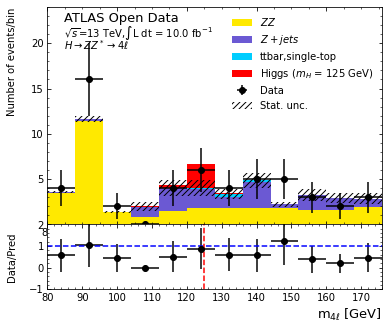

In [24]:
plot_mH(data)

In [25]:
def plot_leadpt(data):

    xmin = 0 
    xmax = 400  
    step_size = 40

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['leadlepton_pt'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['leadlepton_pt']) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Lead $p_{T}$',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of leptons/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    plt.savefig("leadlep_pt.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


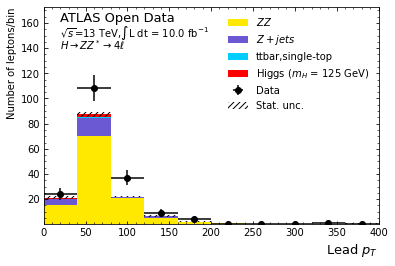

In [26]:
plot_leadpt(data)

In [27]:
def plot_number_leptons(data):

    xmin = 0 
    xmax = 10  
    step_size = 1

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['number_leptons'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['number_leptons']) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Number of leptons',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    plt.savefig("number_leptons.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


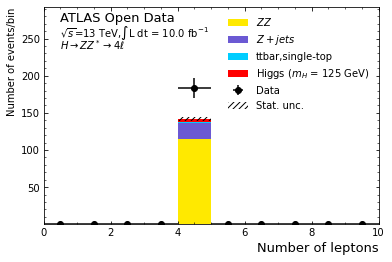

In [28]:
plot_number_leptons(data)

In [29]:
def plot_number_jets(data):

    xmin = 0 
    xmax = 5  
    step_size = 1

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['number_jets'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['number_jets']) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Jets multiplicity',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    plt.savefig("number_jets.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


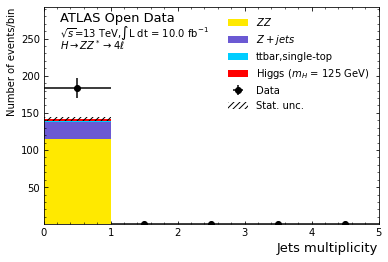

In [30]:
plot_number_jets(data)

In [31]:
def plot_charge(data):

    xmin = -3 
    xmax = 4
    step_size = 1

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['lepton_charge'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['lepton_charge']) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Lepton charge',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    plt.savefig("lepton_charge.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


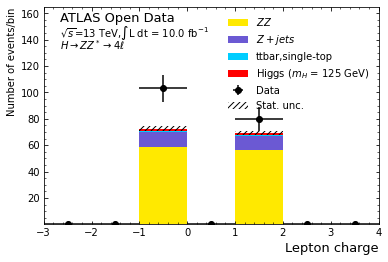

In [32]:
plot_charge(data)

In [33]:
def plot_type(data):

    xmin = 0 
    xmax = 30
    step_size = 1

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['lepton_type'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['lepton_type']) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Lepton type',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    plt.savefig("lepton_type.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


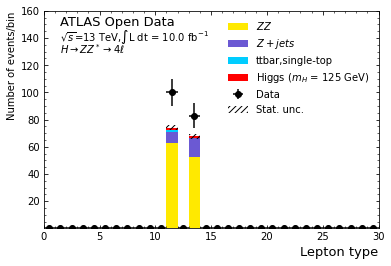

In [34]:
plot_type(data)

In [35]:
def plot_ml1l2(data):

    xmin = 60 #GeV
    xmax = 140  #GeV
    step_size = 5 #Gev/bin

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mll12'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    signal_x = data[r'Higgs ($m_H$ = 125 GeV)']['mll12'] # histogram the signal
    signal_weights = data[r'Higgs ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Higgs ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar


    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Higgs ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mll12'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************
    #plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    #Calculate the Data/Pred. ratio, taking the closest value of the data to the MC value

    data_pred=(data_x-data_x_errors)/mc_x_tot
    #errormc_x_tot=np.sqrt(mc_x_err) #statistical error in MC data
    #data_pred_errors=data_pred*np.sqrt(((data_x-data_x_errors)/data_x_errors)**2+(mc_x_tot/mc_x_err)**2)   
    data_pred_errors=np.sqrt(data_pred) #stat. unc.

    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Higgs ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    #main_axes.set_xlabel(r'$\mathrm{m_{T}(4l)}$ [GeV]',
    #                    fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    """
    plt.text(0.05, # x
             0.76, # y
             'Reproduced it by: B. Castiblanco', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    """
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.125,-0.1,0.775,0.225]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    sub_axes.set_ylim(bottom=0, top=np.amax(data_pred)*1.5)

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_pred, yerr=data_pred_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles

    sub_axes.axhline(1.0,ls='--',c='b')
    #sub_axes.axvline(125.0,ls='--',c='r')                  

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_xticks([80,90,100,110,120,130,140,150,160,170]) 
    
    # x-axis label
    sub_axes.set_xlabel(r'$\mathrm{m_{2\ell_{1}\ell_{2}}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 )
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_yticks([-1.0,0,1.0,2.0])

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Data/Pred' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

    plt.savefig("m_l1l2.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


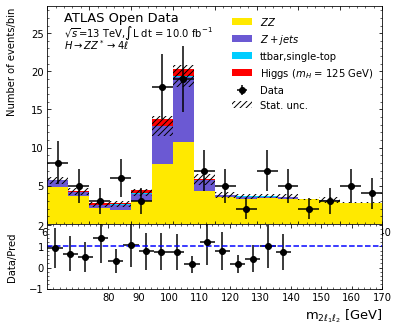

In [36]:
plot_ml1l2(data)

In [37]:
def plot_ml3l4(data):

    xmin = 60 #GeV
    xmax = 140  #GeV
    step_size = 5 #Gev/bin

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mll34'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    signal_x = data[r'Higgs ($m_H$ = 125 GeV)']['mll34'] # histogram the signal
    signal_weights = data[r'Higgs ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Higgs ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar


    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Higgs ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mll34'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************
    #plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    #Calculate the Data/Pred. ratio, taking the closest value of the data to the MC value

    data_pred=(data_x-data_x_errors)/mc_x_tot
    #errormc_x_tot=np.sqrt(mc_x_err) #statistical error in MC data
    #data_pred_errors=data_pred*np.sqrt(((data_x-data_x_errors)/data_x_errors)**2+(mc_x_tot/mc_x_err)**2)   
    data_pred_errors=np.sqrt(data_pred) #stat. unc.

    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Higgs ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    #main_axes.set_xlabel(r'$\mathrm{m_{T}(4l)}$ [GeV]',
    #                    fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    """
    plt.text(0.05, # x
             0.76, # y
             'Reproduced it by: B. Castiblanco', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    """
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.125,-0.1,0.775,0.225]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    sub_axes.set_ylim(bottom=0, top=np.amax(data_pred)*1.5)

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_pred, yerr=data_pred_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles

    sub_axes.axhline(1.0,ls='--',c='b')
    #sub_axes.axvline(125.0,ls='--',c='r')                  

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_xticks([80,90,100,110,120,130,140,150,160,170]) 
    
    # x-axis label
    sub_axes.set_xlabel(r'$\mathrm{m_{2\ell_{3}\ell_{4}}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 )
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_yticks([-1.0,0,1.0,2.0])

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Data/Pred' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

    plt.savefig("m_l3l4.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


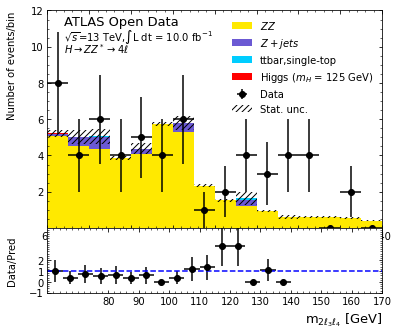

In [38]:
plot_ml3l4(data)

Calculation of some numbers:



*   Number of events selected from the data: 

            Data = 365 events


*   Number of expected signal events:

            S = 385706



*   Number of MC Background events:

           B = 566742


In [ ]:
D=365
S=385706
B=566742

#Data/MC ratio:
D_B=D/B

#The purity of the signal:
P=S/(S+B)

#Approximate significance of our signal (for measurements):
a1=S/math.sqrt(S+B)

#Approximate significance of our signal (for searches):
a2=S/math.sqrt(B)

print("Data/MC ratio:",D_B)
print("Purity of the signal:",P)
print("Approx. significance of our signal for measurements:",a1)
print("Approx. significance of our signal for searches:",a2)